# Emotion Recognition and Neural Network

In this notebook, I'm going to analyze the dataset of 28709 images, each is 48x48 pixel grayscale, to predict 7 face expressions (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral) using convolutional neural network.


## 1.Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix

from PIL import Image


from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import  ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical

import cv2 as cv

In [15]:
df = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [16]:
df.head(3)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...


## 2.Preprocessing

In [17]:
# Emotions distribution
df['emotion'].value_counts()


3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

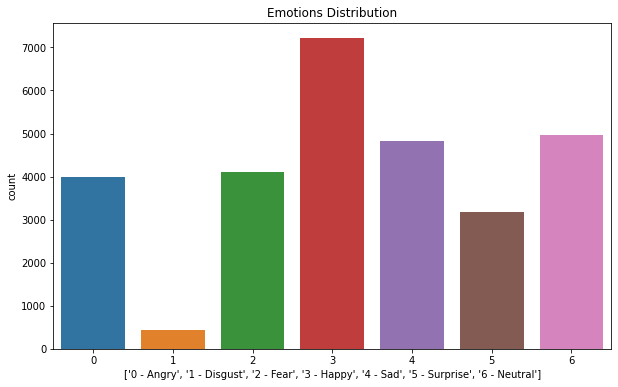

In [18]:
# Visual emotions distributions
plt.figure(figsize = (10,6))

sns.countplot(data = df, x='emotion').set_title('Emotions Distribution')
plt.xlabel(['0 - Angry', '1 - Disgust',  '2 - Fear',  '3 - Happy',  '4 - Sad', '5 - Surprise', '6 - Neutral']);

In [19]:
# function to convert 1d pixels to array
def converter(pixels):
    return np.array(pixels.split(),"float64")

In [20]:
# convert to array
df['pixels_array'] = df["pixels"].apply(converter)
test['pixels'] = test['pixels'].apply(converter)

In [21]:
# Scale
df['pixels_array']/=255.
test['pixels']/=255.

In [22]:
# reshape to 48*48 since the shape of single pic is 2304
image = np.reshape(list(df['pixels_array']),(df.shape[0],48,48,1))
image_test = np.reshape(list(test['pixels']),(test.shape[0],48,48,1))
image.shape

(28709, 48, 48, 1)

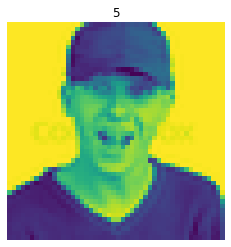

In [23]:
# Check a single image
plt.imshow(image[55])
plt.title(df['emotion'][55])
plt.axis('off');

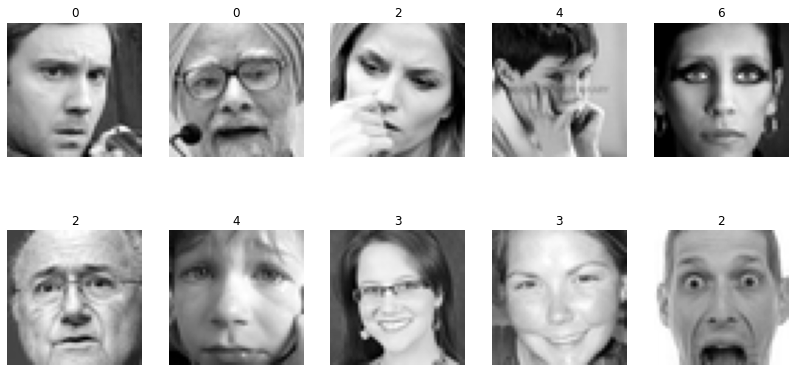

In [24]:
# Look at first 10 images

plt.figure(figsize=[14,7])

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(image[i],cmap="gray")
    plt.title(df['emotion'][i])
    plt.axis("off")
plt.show()

## 3.CNN

In [25]:
# Identify X, y and train_test_split:

X = image    
y = to_categorical(df['emotion'])

X_train,X_val, y_train, y_val = train_test_split(X, y, random_state = 42)

In [26]:
# Baseline score

y.mean(axis=0)

array([0.13915497, 0.01518688, 0.14270785, 0.2513149 , 0.16823992,
       0.11045317, 0.17294228], dtype=float32)

In [27]:
# Instantiate the model

cnn = Sequential()

cnn.add(Conv2D(32, kernel_size = (3,3), activation ='relu', input_shape = (48,48,1)))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size=(2,2)))


cnn.add(Conv2D(64, kernel_size = (3,3), activation ='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size=(2,2)))


cnn.add(Conv2D(128, kernel_size = (3,3), activation ='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size=(2,2)))


cnn.add(Flatten()) 

cnn.add(Dense(512, activation = 'relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(256, activation = 'relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(7, activation = 'softmax'))

In [28]:
# Look at the summary of our model
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 21, 21, 64)       256       
 hNormalization)                                                 
                                                        

In [29]:
# Compile

cnn.compile(loss='categorical_crossentropy', 
#           optimizer = 'adam', 
            optimizer = Adam(learning_rate=0.0001), 
            metrics = ['accuracy'])

In [30]:
# Callbacks

callback_list = [ EarlyStopping( monitor='accuracy', # monitor accuracy
                                 patience=2,    # Training will interrupted when acc stops improving after 1 epoch
                                 restore_best_weights=True),
                  
                  # This callback will save the current weights after every epoch
                  ModelCheckpoint(filepath='./data/save/cnn_weights1', # Path to the destination model file
                                  monitor='val_loss',            # not overwrite the model file unless `val_loss` has improved
                                  save_best_only=True),          # keep the best model every seen during training.
                 
                 # reduce the learning rate when the validation loss has stopped improving
                 # Monitor the validation loss of the model
                  ReduceLROnPlateau(monitor='val_loss',  # Monitor val_loss
                                    factor=0.1,          # It will divide the learning by 10 when it gets triggered
                                    patience=3)]         # It will get triggered after the val_loss has stopped improving
                                                        # for at least 3 epochs


In [31]:
# Fit and train

history = cnn.fit(X_train, y_train,
                  batch_size= 32,
                  validation_data = (X_val, y_val),
                  epochs=23,
                  callbacks = callback_list,
                  verbose=1)

Epoch 1/23
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
673/673 [==============================] - ETA: 0s - loss: 1.8124 - accuracy: 0.3082WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000020C02AB3678> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

Epoch 4/23
673/673 [==============================] - ETA: 0s - loss: 1.3584 - accuracy: 0.4823WARNING:tensorflow:AutoGraph could not transform <function trace_model_call.<locals>._wrapped_model at 0x0000020C597E4438> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full o

INFO:tensorflow:Assets written to: ./data/save\cnn_weights1\assets
673/673 [==============================] - 70s 104ms/step - loss: 1.1104 - accuracy: 0.5868 - val_loss: 1.2758 - val_accuracy: 0.5114 - lr: 1.0000e-04
Epoch 8/23
673/673 [==============================] - ETA: 0s - loss: 1.0201 - accuracy: 0.6218WARNING:tensorflow:AutoGraph could not transform <function trace_model_call.<locals>._wrapped_model at 0x0000020C02C434C8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, deco

## 4.Visualization

In [32]:
# Evaluate  only last epoch
cnn.evaluate(X_val,y_val)

225/225 [==============================] - 5s 23ms/step - loss: 1.3409 - accuracy: 0.5492


[1.3409441709518433, 0.5491780638694763]

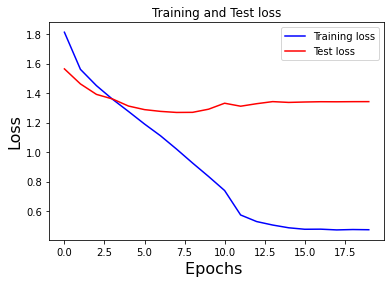

<Figure size 432x288 with 0 Axes>

In [33]:
# Look at the train and test loss

train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show();

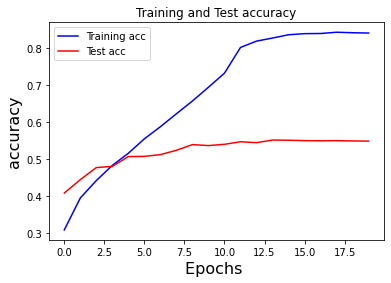

<Figure size 432x288 with 0 Axes>

In [34]:
# Look at the train and test accuracy

train_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']


plt.plot(range(len(train_loss)), train_loss, 'b', label='Training acc')
plt.plot(range(len(train_loss)), test_loss, 'r', label='Test acc')
plt.title('Training and Test accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('accuracy',fontsize=16)
plt.legend()
plt.figure()
plt.show();

## 5.Data Augmentation and Convnets

In [38]:
# Preparation for the modeling


datagen = ImageDataGenerator( rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True)

history1 = cnn.fit(x = datagen.flow(X_train, y_train, batch_size=32),
                                   steps_per_epoch= len(X_train)/32,
                                   validation_data=(X_val, y_val),
                                   epochs=2,
                                   verbose=0)

In [39]:
cnn.evaluate(X_val,y_val)

225/225 [==============================] - 6s 24ms/step - loss: 1.3973 - accuracy: 0.5450


[1.3972864151000977, 0.5449985861778259]

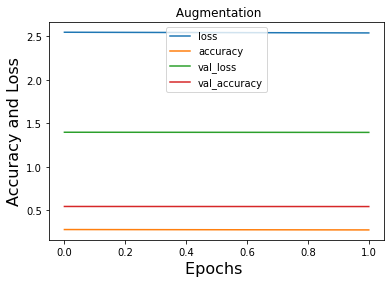

In [40]:
# Let's look at loss and accuracy together

for key in history1.history.keys():
    plt.plot(history1.history[key], label=key)
    
plt.title(' Augmentation')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy and Loss',fontsize=16)
plt.legend();

## 6.Evaluate predictions

In [41]:
# make predictions on a new data

pred_train = cnn.predict(X_val)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [42]:
# Convert np.arrays to actual images

predicted_images = [np.argmax(i) for i in pred_train]
original_images = [np.argmax(i) for i in y_val]

In [43]:
# Print classification report

print(classification_report(original_images, predicted_images))

              precision    recall  f1-score   support

           0       0.40      0.44      0.42       945
           1       0.54      0.21      0.30        99
           2       0.42      0.35      0.38      1025
           3       0.71      0.80      0.75      1823
           4       0.46      0.37      0.41      1245
           5       0.68      0.69      0.69       819
           6       0.47      0.52      0.49      1222

    accuracy                           0.54      7178
   macro avg       0.53      0.48      0.49      7178
weighted avg       0.54      0.54      0.54      7178



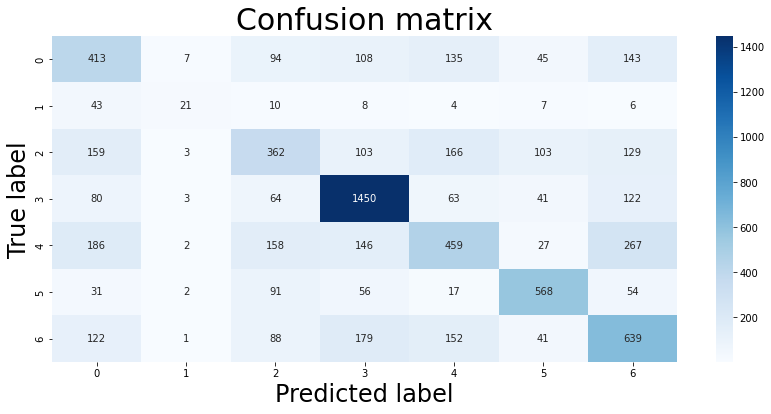

In [44]:
# Print Confusion matrix

plt.figure(figsize=(14,6))
sns.heatmap(confusion_matrix(original_images,predicted_images),annot = True, fmt= "d", cmap = "Blues")
plt.title('Confusion matrix', fontsize = 30)
plt.ylabel('True label', fontsize=24)
plt.xlabel('Predicted label', fontsize = 24);

## 7.Predict labels on new images

In [45]:
# predict 
pred_test = cnn.predict(image_test)

In [46]:
# save predictions and add to df
test['Label_Aug'] = pred_test.argmax(axis = 1)
test.head(4)

,pixels,Label_Aug
0,"[0.996078431372549, 0.996078431372549, 0.99607...",2
1,"[0.611764705882353, 0.7215686274509804, 0.7764...",3
2,"[0.27058823529411763, 0.4627450980392157, 0.23...",0
3,"[0.803921568627451, 0.796078431372549, 0.92549...",4


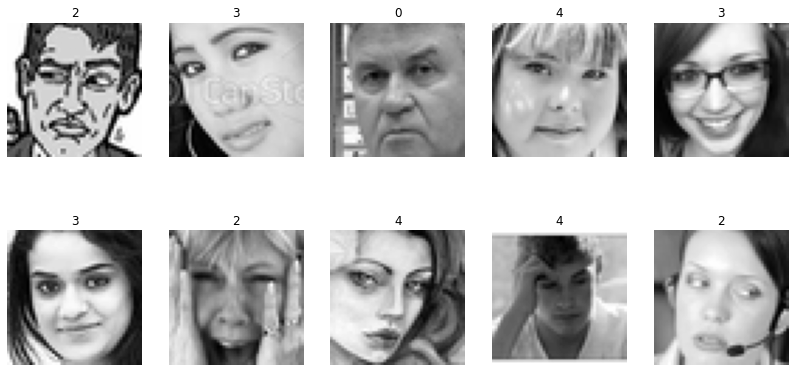

In [47]:
# Look at the first 10 images
# reshape prediction images to 48 by 48 since our len of single image test.pixels[0] is 2304

final_image = np.reshape(test['pixels'].to_list(),(test.shape[0],48,48,1))

#final_image = final_image[60:100]

plt.figure(figsize=[14,7])

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(final_image[i],cmap="gray")
    plt.title(test['Label_Aug'][i])
    plt.axis("off")
plt.show()

In [48]:
['0 - Angry', '1 - Disgust',  '2 - Fear',  '3 - Happy',  '4 - Sad', '5 - Surprise', '6 - Neutral']

['0 - Angry',
 '1 - Disgust',
 '2 - Fear',
 '3 - Happy',
 '4 - Sad',
 '5 - Surprise',
 '6 - Neutral']